# this is a step by step guide to load the pretrained double pendulum (LSTM_PENDULUM.pt) model that i train on my rusty rtx3050 

In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm
import numpy as np
from pathlib import Path

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class FullSequenceDataset(torch.utils.data.Dataset):
    def __init__(self, trail_dir, state_dir, label_dir):
        self.trail_dir = Path(trail_dir)
        self.state_dir = Path(state_dir)
        self.label_dir = Path(label_dir)
        self.sample_ids = sorted([f.stem for f in self.trail_dir.glob("*.npy")])

    def __len__(self):
        return len(self.sample_ids)

    def __getitem__(self, idx):
        sample_id = self.sample_ids[idx]
        trail = np.load(self.trail_dir / f"{sample_id}.npy")   # (300, 2)
        state = np.load(self.state_dir / f"{sample_id}.npy")   # (300, 4)
        label = np.load(self.label_dir / f"{sample_id}.npy")   # (4,)
        input_seq = np.concatenate([trail, state], axis=1)     # (300, 6)
        return torch.tensor(input_seq, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

In [6]:
# Set paths
trail_path = "dataset/trails"
state_path = "dataset/states"
label_path = "dataset/labels"
# Load dataset and split
full_dataset = FullSequenceDataset(trail_path, state_path, label_path)
n = len(full_dataset)
test_size = int(0.1 * n)
val_size = int(0.1 * n)
train_size = n - test_size - val_size

_, _, test_set = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])
test_loader = DataLoader(test_set, batch_size=32)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.jit.load("LSTM_PENDULUM.pt")
model = model.to(device)
model.eval()

RecursiveScriptModule(
  original_name=PendulumFullLSTM
  (lstm): RecursiveScriptModule(original_name=LSTM)
  (fc): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=Linear)
    (3): RecursiveScriptModule(original_name=ReLU)
    (4): RecursiveScriptModule(original_name=Linear)
  )
)

In [10]:
criterion = nn.MSELoss()
test_loss = 0.0

with torch.no_grad():
    for inputs, targets in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print(f"Test MSE Loss: {avg_test_loss:.6f}")

Testing: 100%|██████████| 32/32 [00:01<00:00, 27.74it/s]

Test MSE Loss: 0.000201


In [11]:
def test_single_sample(index=None):
    if index is None:
        index = random.randint(0, len(test_set) - 1)
    x, y_true = test_set[index]
    x = x.unsqueeze(0).to(device)
    with torch.no_grad():
        y_pred = model(x).cpu().numpy().flatten()
    print(f"Sample #{index}")
    print("True     :", y_true.numpy())
    print("Predicted:", y_pred)

In [25]:
len(test_set)

1000

In [24]:
test_single_sample(69)

Sample #69
True     : [ 2.216845    0.6956586   1.3167913  -0.72823745]
Predicted: [ 2.195375   0.705164   1.3060037 -0.7550562]


In [13]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Physical constants
g = 9.81
L1, L2 = 1.5, 1.5
m1, m2 = 1.0, 1.0

# Pendulum equations
def equations(t, y):
    θ1, z1, θ2, z2 = y
    Δ = θ2 - θ1

    den1 = (m1 + m2) * L1 - m2 * L1 * np.cos(Δ)**2
    den2 = (L2 / L1) * den1

    dz1 = (m2 * L1 * z1**2 * np.sin(Δ) * np.cos(Δ)
           + m2 * g * np.sin(θ2) * np.cos(Δ)
           + m2 * L2 * z2**2 * np.sin(Δ)
           - (m1 + m2) * g * np.sin(θ1)) / den1

    dz2 = (-m2 * L2 * z2**2 * np.sin(Δ) * np.cos(Δ)
           + (m1 + m2) * g * np.sin(θ1) * np.cos(Δ)
           - (m1 + m2) * L1 * z1**2 * np.sin(Δ)
           - (m1 + m2) * g * np.sin(θ2)) / den2

    return [z1, dz1, z2, dz2]

# Simulate (x2, y2) from initial state
def simulate_from_state(state, T=5.0, fps=60):
    θ1, ω1, θ2, ω2 = state
    y0 = [θ1, ω1, θ2, ω2]
    t_eval = np.linspace(0, T, int(T * fps))

    sol = solve_ivp(equations, [0, T], y0, t_eval=t_eval, rtol=1e-10, atol=1e-10)
    θ1, θ2 = sol.y[0], sol.y[2]

    x1 = L1 * np.sin(θ1)
    y1 = -L1 * np.cos(θ1)
    x2 = x1 + L2 * np.sin(θ2)
    y2 = y1 - L2 * np.cos(θ2)
    return x2, y2

# Compare prediction and truth
def show_comparison(pred_label, true_label, figsize=(5, 3), T=5, fps=60):
    x2_pred, y2_pred = simulate_from_state(pred_label, T=T, fps=fps)
    x2_true, y2_true = simulate_from_state(true_label, T=T, fps=fps)

    all_x = np.concatenate([x2_pred, x2_true])
    all_y = np.concatenate([y2_pred, y2_true])
    max_range = max(np.abs(all_x).max(), np.abs(all_y).max()) * 1.1

    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes[0].plot(x2_true, y2_true, color='black', linewidth=1)
    axes[0].set_xlim(-max_range, max_range)
    axes[0].set_ylim(-max_range, max_range)
    axes[0].set_aspect('equal')
    axes[0].set_title("Truth Trail")
    axes[0].axis('off')

    axes[1].plot(x2_pred, y2_pred, color='black', linewidth=1)
    axes[1].set_xlim(-max_range, max_range)
    axes[1].set_ylim(-max_range, max_range)
    axes[1].set_aspect('equal')
    axes[1].set_title("Predicted Trail")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

def test_and_visualize_sample(model, test_set, device, index=None):
    if index is None:
        index = random.randint(0, len(test_set) - 1)

    seq, true_label = test_set[index]
    seq = seq.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(seq).cpu()
        pred_label = output.numpy().flatten()

    show_comparison(pred_label, true_label)
    print(f"Sample Index: {index}")
    print(f"True Label   : {true_label.numpy()}")
    print(f"Predicted    : {pred_label}")


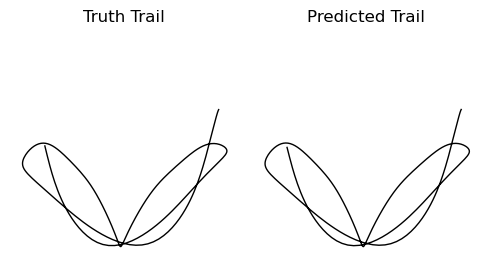

Sample Index: 280
True Label   : [ 1.6806791  -0.98750716  2.142223    0.6625823 ]
Predicted    : [ 1.684851   -0.97930783  2.1399188   0.66282624]


In [20]:
# Random sample
test_and_visualize_sample(model, test_set, device)

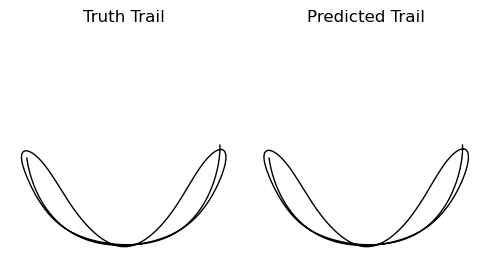

Sample Index: 19
True Label   : [ 1.1722702 -0.4726201  1.9307501 -0.7472054]
Predicted    : [ 1.1762829  -0.48097038  1.9273733  -0.75801444]


In [17]:
# Specific index
test_and_visualize_sample(model, test_set, device, index=19)

hope it helped u.
thanks :)